# Amazon Forecast  Sample Inventory Planning

Sample INVENTORY_PLANNING for  bike rentals. The bike rental data came from the [Kaggle Bike Share dataset](https://www.kaggle.com/c/bike-sharing-demand) 

Prerequisites: 
[AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/installing.html) . 

For more informations about APIs, please check the [documentation](https://docs.aws.amazon.com/forecast/latest/dg/what-is-forecast.html)

## Table Of Contents
* [Setting up](#setup)
* [Test Setup - Running first API](#hello)
* [Forecasting Example with Amazon Forecast](#forecastingExample)

**Read Every Cell FULLY before executing it**


## Set up Preview SDK<a class="anchor" id="setup"></a>

In [54]:
# Configures your AWS CLI to now understand our up and coming service Amazon Forecast
!aws configure add-model --service-model file://../sdk/forecastquery-2018-06-26.normal.json --service-name forecastquery
!aws configure add-model --service-model file://../sdk/forecast-2018-06-26.normal.json --service-name forecast

In [55]:
# Prerequisites : 1 time install only, remove the comments to execute the lines.
#!pip install boto3
#!pip install pandas

In [56]:
import boto3
from time import sleep
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline


In [57]:
session = boto3.Session(region_name='us-west-2') #us-east-1 is also supported

forecast = session.client(service_name='forecast')
forecastquery = session.client(service_name='forecastquery')

##  Setup <a class="anchor" id="hello"></a>
We will confirm that the notebook can access  Amazon Forecast and  interact with our Simple API ListRecipes. The API returns a list of the global recipes Forecast offers that you could potentially use as a part of your forecasting solution. 

In [58]:
forecast.list_recipes()

{'RecipeNames': ['forecast_ARIMA',
  'forecast_DEEP_AR',
  'forecast_DEEP_AR_PLUS',
  'forecast_ETS',
  'forecast_MDN',
  'forecast_MQRNN',
  'forecast_NPTS',
  'forecast_PROPHET',
  'forecast_SQF'],
 'ResponseMetadata': {'RequestId': 'bda356a8-8fcd-488d-85d3-2f8a4f31c564',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 18 Jan 2019 16:58:41 GMT',
   'x-amzn-requestid': 'bda356a8-8fcd-488d-85d3-2f8a4f31c564',
   'content-length': '174',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

*If this ran successfully, kudos! If there are any errors at this point runing the following list_recipes, please contact us at the [AWS support forum](https://forums.aws.amazon.com/forum.jspa?forumID=327)

## Forecasting with Amazon Forecast<a class="anchor" id="forecastingExample"></a>
### Preparing your Data

In Amazon Forecast , a dataset is a collection of file(s) which contain data that is relevant for a forecasting task. A dataset must conform to a schema provided by Amazon Forecast. 

For this exercise, we use sample bike share rental dataset. 

# Data Pre-processing 
  Amazon forecast can import data from Amazon S3. We first explore the data locally to see the attributes . We are using all the attriutes , so the user can modify the attributes to see the different results. 
  IF you remove any attributes , those changes must be reflected in 

In [59]:
import pandas as pd
trf = pd.read_csv("../data/train.csv", dtype = object)
trf['count'] = trf['count'].astype(float) 
trf['itemname'] = 'bike_12'
trf.to_csv("../data/bike.csv", index= False, header = False)
trf.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,itemname
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16.0,bike_12
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40.0,bike_12
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32.0,bike_12


In [60]:
df = pd.read_csv("../data/bike.csv", dtype = object)
df.head(3)


,2011-01-01 00:00:00,1,0,0.1,1.1,9.84,14.395,81,0.2,3,13,16.0,bike_12
0,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40.0,bike_12
1,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32.0,bike_12
2,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13.0,bike_12


Now upload the data to S3. But before doing that, go into your AWS Console, select S3 for the service and create a new bucket inside the `Oregon` or `us-west-2` region. Use that bucket name convention of `amazon-forecast-unique-value-data`. The name must be unique, if you get an error, just adjust until your name works, then update the `bucketName` cell below.

In [61]:
s3 = session.client('s3')

In [62]:
accountId = boto3.client('sts').get_caller_identity().get('Account')

In [63]:
bucketName = "amazon-forecast-data-{0}".format(accountId)# Update the unique-value bit here.
key="bikedata/bike.csv"

In [64]:
s3.upload_file(Filename="../data/bike.csv", Bucket=bucketName, Key=key)

In [65]:
bucketName

'amazon-forecast-data-983739021977'

In [66]:
# One time setup only, uncomment the following command to create the role to provide to Amazon Forecast. 
# Save the generated role for all future calls to use for importing or exporting data. 

cmd = 'python ../setup_forecast_permissions.py '+bucketName
p = subprocess.Popen(cmd.split(' '), stdout=subprocess.PIPE, stderr=subprocess.PIPE)

In [67]:
roleArn = 'arn:aws:iam::%s:role/amazonforecast'%accountId

### CreateDataset

More details about `Domain` and dataset type can be found on the [documentation](https://docs.aws.amazon.com/forecast/latest/dg/howitworks-domains-ds-types.html) . For this example, we are using [RETAIL](https://docs.aws.amazon.com/forecast/latest/dg/retail-domain.html) domain with 3 required attributes `timestamp`, `demand` and `item_id`. Also for your project name, update it to reflect your name in a lowercase format.

In [68]:
DATASET_FREQUENCY = "H" 
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"

In [69]:
project = 'bike_forecastdemo' # Replace this with a unique name here, make sure the entire name is < 30 characters.
datasetName= project+'_ds'
datasetGroupName= project +'_gp'
s3DataPath = "s3://"+bucketName+"/"+key
s3DataPath

's3://amazon-forecast-data-983739021977/bikedata/bike.csv'

In [70]:
datasetName

'bike_forecastdemo_ds'

In [71]:
### Schema Definition 
### We are defining the attributes for the model 

In [72]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
schema ={
   "Attributes":[    
      { "AttributeName":"timestamp",     "AttributeType":"timestamp"    },      
      { "AttributeName":"season",        "AttributeType":"integer"      },      
      { "AttributeName":"holiday",       "AttributeType":"integer"      },      
      { "AttributeName":"workday",       "AttributeType":"integer"      },      
      { "AttributeName":"weather",       "AttributeType":"integer"      },     
      { "AttributeName":"temperature",   "AttributeType":"float"        },       
      { "AttributeName":"atemp",         "AttributeType":"float"        }, 
      { "AttributeName":"humidity",      "AttributeType":"integer"      },       
      { "AttributeName":"windspeed",     "AttributeType":"float"      },       
      { "AttributeName":"casual",        "AttributeType":"integer"      },      
      { "AttributeName":"registered",    "AttributeType":"integer"      },         
      { "AttributeName":"demand",         "AttributeType":"float"       },      
      { "AttributeName":"item_id",       "AttributeType":"string"       }       
  ]
}

response=forecast.create_dataset(
                    Domain="RETAIL",
                    DatasetType='TARGET_TIME_SERIES',
                    DataFormat='CSV',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    TimeStampFormat=TIMESTAMP_FORMAT,
                    Schema = schema
                   )

In [73]:
forecast.describe_dataset(DatasetName=datasetName)

{'DatasetName': 'bike_forecastdemo_ds',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFormat': 'CSV',
 'Domain': 'RETAIL',
 'ScheduleExpression': 'none',
 'DatasetArn': 'arn:aws:forecast:us-west-2:983739021977:ds/bike_forecastdemo_ds',
 'Status': 'ACTIVE',
 'ResponseMetadata': {'RequestId': 'aa5570a8-9bb8-4f24-9361-951a811474c8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 18 Jan 2019 16:59:08 GMT',
   'x-amzn-requestid': 'aa5570a8-9bb8-4f24-9361-951a811474c8',
   'content-length': '235',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [74]:
forecast.create_dataset_group(DatasetGroupName=datasetGroupName,RoleArn=roleArn,DatasetNames=[datasetName])

{'DatasetGroupName': 'bike_forecastdemo_gp',
 'DatasetGroupArn': 'arn:aws:forecast:us-west-2:983739021977:dsgroup/bike_forecastdemo_gp',
 'ResponseMetadata': {'RequestId': '43227c1b-8881-4ff8-8bfb-bc27ef3e90ba',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 18 Jan 2019 16:59:09 GMT',
   'x-amzn-requestid': '43227c1b-8881-4ff8-8bfb-bc27ef3e90ba',
   'content-length': '132',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

If you have an existing datasetgroup, you can update it

In [75]:
forecast.describe_dataset_group(DatasetGroupName=datasetGroupName)

{'DatasetGroupName': 'bike_forecastdemo_gp',
 'DatasetGroupArn': 'arn:aws:forecast:us-west-2:983739021977:dsgroup/bike_forecastdemo_gp',
 'Datasets': ['bike_forecastdemo_ds'],
 'RoleArn': 'arn:aws:iam::983739021977:role/amazonforecast',
 'ResponseMetadata': {'RequestId': 'b786ac3c-a1c2-4a3e-9859-6971d9942fb9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 18 Jan 2019 16:59:11 GMT',
   'x-amzn-requestid': 'b786ac3c-a1c2-4a3e-9859-6971d9942fb9',
   'content-length': '226',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### Create Data Import Job
Brings the data into Amazon Forecast system ready to forecast from raw data. 

In [76]:
ds_import_job_response=forecast.create_dataset_import_job(DatasetName=datasetName,Delimiter=',', DatasetGroupName =datasetGroupName ,S3Uri= s3DataPath)


In [77]:
ds_versionId=ds_import_job_response['VersionId']
print(ds_versionId)

b6c01436


Check the status of dataset, when the status change from **CREATING** to **ACTIVE**, we can continue to next steps. Depending on the data size. It can take 10 mins to be **ACTIVE**. This process will take 5 to 10 minutes.

In [79]:
while True:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetName=datasetName,VersionId=ds_versionId)['Status']
    print(dataImportStatus)
    if dataImportStatus != 'ACTIVE' and dataImportStatus != 'FAILED':
        sleep(30)
    else:
        break

ACTIVE


In [80]:
forecast.describe_dataset_import_job(DatasetName=datasetName,VersionId=ds_versionId)

{'DatasetArn': 'arn:aws:forecast:us-west-2:983739021977:ds/bike_forecastdemo_ds',
 'DatasetName': 'bike_forecastdemo_ds',
 'VersionId': 'b6c01436',
 'Status': 'ACTIVE',
 'FieldStatistics': {'atemp': {'Count': 10886,
   'CountDistinct': 60,
   'CountNull': 0,
   'Min': '0.76',
   'Max': '45.455',
   'Avg': 23.65508405291201,
   'Stddev': 8.474600626484948},
  'casual': {'Count': 10886,
   'CountDistinct': 309,
   'CountNull': 0,
   'Min': '0',
   'Max': '367',
   'Avg': 36.02195480433584,
   'Stddev': 49.960476572649526},
  'date': {'Count': 10886,
   'CountDistinct': 10886,
   'CountNull': 0,
   'Min': '2011-01-01T00:00:00Z',
   'Max': '2012-12-19T23:00:00Z'},
  'holiday': {'Count': 10886,
   'CountDistinct': 2,
   'CountNull': 0,
   'Min': '0',
   'Max': '1',
   'Avg': 0.02856880396839978,
   'Stddev': 0.16659885062470958},
  'humidity': {'Count': 10886,
   'CountDistinct': 89,
   'CountNull': 0,
   'Min': '0',
   'Max': '100',
   'Avg': 61.88645967297446,
   'Stddev': 19.245033277394

### Recipe

In [81]:
recipesResponse=forecast.list_recipes()
recipesResponse

{'RecipeNames': ['forecast_ARIMA',
  'forecast_DEEP_AR',
  'forecast_DEEP_AR_PLUS',
  'forecast_ETS',
  'forecast_MDN',
  'forecast_MQRNN',
  'forecast_NPTS',
  'forecast_PROPHET',
  'forecast_SQF'],
 'ResponseMetadata': {'RequestId': 'c7f1f54c-92e7-4876-a741-8e991b097628',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 18 Jan 2019 17:14:13 GMT',
   'x-amzn-requestid': 'c7f1f54c-92e7-4876-a741-8e991b097628',
   'content-length': '174',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

Get details about each recipe.

In [82]:
forecast.describe_recipe(RecipeName='forecast_MQRNN')

{'Recipe': {'Name': 'forecast_MQRNN',
  'Train': [{'TrainingInfo': {'TrainedModelName': 'algorithm_MQRNN',
     'AlgorithmName': 'MQRNN',
     'TrainingParameters': {'epochs': '60',
      'learning_rate': '3E-3',
      'mini_batch_size': '32',
      'quantiles': '[0.1,0.5,0.9]'}},
    'BackTestWindowCount': 1,
    'MetricsBuckets': []}]},
 'ResponseMetadata': {'RequestId': '373272a3-2d3f-4691-b61f-8b0484443c3d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 18 Jan 2019 17:14:14 GMT',
   'x-amzn-requestid': '373272a3-2d3f-4691-b61f-8b0484443c3d',
   'content-length': '281',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### Create Solution 

Forecast horizon is how long in future the forecast should be predicting. For weekly data, a value of 12 means 1 weeks. Our example is hourly data, we try forecast the next day, so we can set to 24.

In [83]:
predictorName= project+'_mqrnn'

In [84]:
forecastHorizon = 24

In [85]:
createPredictorResponse=forecast.create_predictor(RecipeName='forecast_MQRNN',DatasetGroupName= datasetGroupName ,PredictorName=predictorName, 
  ForecastHorizon = forecastHorizon)

In [86]:
predictorVerionId=createPredictorResponse['VersionId']

In [87]:
forecast.list_predictor_versions(PredictorName=predictorName)

{'PredictorVersions': [{'PredictorName': 'bike_forecastdemo_mqrnn',
   'VersionId': '88b88708'}],
 'ResponseMetadata': {'RequestId': 'ecd88c44-0079-4ba7-89c6-17cb77955a6a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 18 Jan 2019 17:14:22 GMT',
   'x-amzn-requestid': 'ecd88c44-0079-4ba7-89c6-17cb77955a6a',
   'content-length': '90',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

Check the status of solutions, when the status change from **CREATING** to **ACTIVE**, we can continue to next steps. Depending on data size, model selection and hyper parameters，it can take 10 mins to more than one hour to be **ACTIVE**.

In [88]:
while True:
    predictorStatus = forecast.describe_predictor(PredictorName=predictorName,VersionId=predictorVerionId)['Status']
    print(predictorStatus)
    if predictorStatus != 'ACTIVE' and predictorStatus != 'FAILED':
        sleep(30)
    else:
        break

CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
ACTIVE


### Get Error Metrics
 This provides metrics on the accuracy of the models that was  trained with the CreatePredictor operation.
 Use metrics to see how well the model did and to decide whether to use the predictor to generate forecasts 

In [89]:
forecastquery.get_accuracy_metrics(PredictorName=predictorName)

{'ModelMetrics': {'MQRNN': {'Metrics': {'p10': '0.1949177072965521',
    'p50': '0.6977204438153599',
    'p90': '0.384952153629007',
    'rmse': '203.7762835394584'},
   'MetricsByBucket': []}},
 'ResponseMetadata': {'RequestId': 'cc6d63c9-9585-44f8-8332-5fed46717508',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 18 Jan 2019 17:55:32 GMT',
   'x-amzn-requestid': 'cc6d63c9-9585-44f8-8332-5fed46717508',
   'content-length': '168',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### Deploy Predictor

In [90]:
forecast.deploy_predictor(PredictorName=predictorName)

{'PredictorName': 'bike_forecastdemo_mqrnn',
 'VersionId': '88b88708',
 'PredictorArn': 'arn:aws:forecast:us-west-2:983739021977:predictor/bike_forecastdemo_mqrnn',
 'ResponseMetadata': {'RequestId': 'f5d440f3-a6d7-4943-b7b3-5f6b37cb9762',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 18 Jan 2019 17:55:34 GMT',
   'x-amzn-requestid': 'f5d440f3-a6d7-4943-b7b3-5f6b37cb9762',
   'content-length': '157',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [91]:
deployedPredictorsResponse=forecast.list_deployed_predictors()
print(deployedPredictorsResponse)

{'PredictorNames': ['bike_forecastdemo_mqrnn', 'workshop_mqrnn'], 'ResponseMetadata': {'RequestId': '88e61eb1-72fd-4cb2-8ffb-01780e2a6c2d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Fri, 18 Jan 2019 17:55:35 GMT', 'x-amzn-requestid': '88e61eb1-72fd-4cb2-8ffb-01780e2a6c2d', 'content-length': '63', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


Please note that the following cell can also take 10 minutes or more to be fully operational. There's no output here, but that is fine as long as the * is there.

In [92]:
while True:
    deployedPredictorStatus = forecast.describe_deployed_predictor(PredictorName=predictorName)['Status']
    print(deployedPredictorStatus)
    if deployedPredictorStatus != 'ACTIVE' and deployedPredictorStatus != 'FAILED':
        sleep(30)
    else:
        break
print(deployedPredictorStatus)

CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
ACTIVE
ACTIVE


### Get Forecast

When the solution is deployed and forecast results are ready, you can view them. 
The result set shows the predictions and confidence on the p10,p50 rates. 

In [93]:
 forecastResponse = forecastquery.get_forecast(
    PredictorName=predictorName,
    Interval="hour",
   Filters={"item_id":"bike_12"}
)
print(forecastResponse)

{'Forecast': {'ForecastId': '1547835214_8e13fa58', 'Predictions': {'mean': [{'Date': '2012-12-20T00:00:00', 'Val': 134.7437744140625}, {'Date': '2012-12-20T01:00:00', 'Val': 132.46299743652344}, {'Date': '2012-12-20T02:00:00', 'Val': 129.3612823486328}, {'Date': '2012-12-20T03:00:00', 'Val': 132.61598205566406}, {'Date': '2012-12-20T04:00:00', 'Val': 137.11630249023438}, {'Date': '2012-12-20T05:00:00', 'Val': 140.5736083984375}, {'Date': '2012-12-20T06:00:00', 'Val': 141.47946166992188}, {'Date': '2012-12-20T07:00:00', 'Val': 139.3992462158203}, {'Date': '2012-12-20T08:00:00', 'Val': 138.3409423828125}, {'Date': '2012-12-20T09:00:00', 'Val': 136.10458374023438}, {'Date': '2012-12-20T10:00:00', 'Val': 133.51535034179688}, {'Date': '2012-12-20T11:00:00', 'Val': 130.5144500732422}, {'Date': '2012-12-20T12:00:00', 'Val': 129.41046142578125}, {'Date': '2012-12-20T13:00:00', 'Val': 128.224609375}, {'Date': '2012-12-20T14:00:00', 'Val': 128.69000244140625}, {'Date': '2012-12-20T15:00:00', 'Va

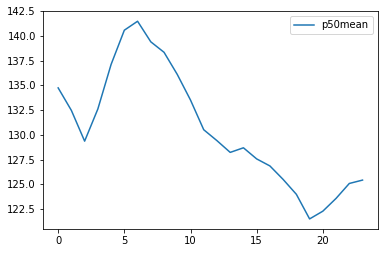

In [111]:
## Generate Plot 
d = pd.DataFrame.from_dict(forecastResponse['Forecast'])
df = pd.DataFrame.from_dict(d.loc['mean']['Predictions']).dropna().rename(columns = {'Val':'p50mean'})
df.plot()

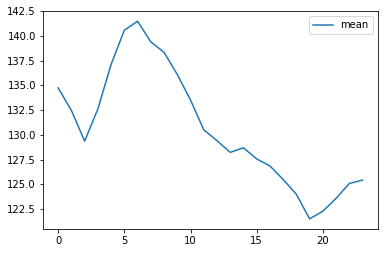

In [110]:
## Generate Plot 
d = pd.DataFrame.from_dict(forecastResponse['Forecast'])
##df = pd.DataFrame.from_dict(d.loc['mean']['Predictions']).dropna().rename(columns = {'Val':'p90'})
df = pd.DataFrame.from_dict(d.loc['mean']['Predictions']).dropna().rename(columns = {'Val':'p90mean'})
df.plot()

# Export Forecast

You can batch export forecast to s3 bucket. To do so an role with s3 put access is needed, but this has already been created.

In [96]:
forecastInfoList= forecast.list_forecasts(PredictorName=predictorName)['ForecastInfoList']
forecastId= forecastInfoList[0]['ForecastId']

In [97]:
outputPath="s3://"+bucketName+"/output"

In [98]:
forecastExportResponse = forecast.create_forecast_export_job(ForecastId=forecastId, OutputPath={"S3Uri": outputPath,"RoleArn":roleArn})

In [99]:
forecastExportJobId = forecastExportResponse['ForecastExportJobId']

In [100]:
while True:
    forecastExportStatus = forecast.describe_forecast_export_job(ForecastExportJobId=forecastExportJobId)['Status']
    print(forecastExportStatus)
    if forecastExportStatus != 'ACTIVE' and forecastExportStatus != 'FAILED':
        sleep(30)
    else:
        break

CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
C

KeyboardInterrupt: 

Check s3 bucket for results

In [ ]:
s3.list_objects(Bucket=bucketName,Prefix="output")

# Cleanup

While Forecast is in preview there are no charges for using it, but to future proof this work below are the instructions to cleanup your work space.

In [112]:
# Delete Deployed Predictor 
forecast.delete_deployed_predictor(PredictorName=predictorName)

{'PredictorName': 'bike_forecastdemo_mqrnn',
 'ResponseMetadata': {'RequestId': '2b6abec8-8e66-4e86-99d5-57f1958d8242',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 18 Jan 2019 21:14:51 GMT',
   'x-amzn-requestid': '2b6abec8-8e66-4e86-99d5-57f1958d8242',
   'content-length': '43',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [113]:
# Delete the Predictor: 
forecast.delete_predictor(PredictorName=predictorName)

InvalidStateException: An error occurred (InvalidStateException) when calling the DeletePredictor operation: There are deployed predictors that exist for this predictorbike_forecastdemo_mqrnn. Please delete any deployed predictors before deleting this predictor

In [114]:
# Delete Import
forecast.delete_dataset_import(DatasetName=datasetName)

InvalidStateException: An error occurred (InvalidStateException) when calling the DeleteDatasetImport operation: There are predictors which still exist that are dependent on this data. Please delete those predictors before deleting this dataset

In [115]:
# Delete Dataset Group
forecast.delete_dataset_group(DatasetGroupName=datasetGroupName)

InvalidStateException: An error occurred (InvalidStateException) when calling the DeleteDatasetGroup operation: Please delete all the datasets in this dataset group before deleting the dataset group